In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x20302aeb188>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'tobs': 65.0,
 'id': 1,
 'date': '2010-01-01'}

In [12]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x20302ac5988>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'station': 'USC00519397',
 'latitude': 21.2716}

# Exploratory Climate Analysis

In [13]:
## Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"Last Date: {date}")

Last Date: ('2017-08-23',)


In [14]:
# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date,
                     func.avg(Measurement.prcp)).filter(Measurement.date<=date[0]).\
                        filter(Measurement.date>='2016-08-24').\
                        group_by(Measurement.date).all()
for row in data:
    print(row)

('2016-08-24', 1.5549999999999997)
('2016-08-25', 0.07714285714285715)
('2016-08-26', 0.016666666666666666)
('2016-08-27', 0.06399999999999999)
('2016-08-28', 0.5166666666666666)
('2016-08-29', 0.24333333333333332)
('2016-08-30', 0.011666666666666667)
('2016-08-31', 0.6359999999999999)
('2016-09-01', 0.006)
('2016-09-02', 0.05)
('2016-09-03', 0.254)
('2016-09-04', 0.276)
('2016-09-05', 0.08499999999999999)
('2016-09-06', 0.246)
('2016-09-07', 0.3333333333333333)
('2016-09-08', 0.07666666666666667)
('2016-09-09', 0.17833333333333332)
('2016-09-10', 0.27999999999999997)
('2016-09-11', 0.25)
('2016-09-12', 0.308)
('2016-09-13', 0.45166666666666666)
('2016-09-14', 2.3800000000000003)
('2016-09-15', 0.8266666666666667)
('2016-09-16', 0.11714285714285715)
('2016-09-17', 0.13599999999999998)
('2016-09-18', 0.10600000000000001)
('2016-09-19', 0.064)
('2016-09-20', 0.14714285714285716)
('2016-09-21', 0.19499999999999998)
('2016-09-22', 0.2057142857142857)
('2016-09-23', 0.22428571428571428)
('2

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(data, columns = ['Date','Precipitation'])
dtformat = pd.to_datetime(df['Date'])
df['Date'] = dtformat
df.set_index('Date',inplace=True)
df

,Precipitation
Date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667
...,...
2017-08-19,0.030000
2017-08-20,0.005000
2017-08-21,0.193333


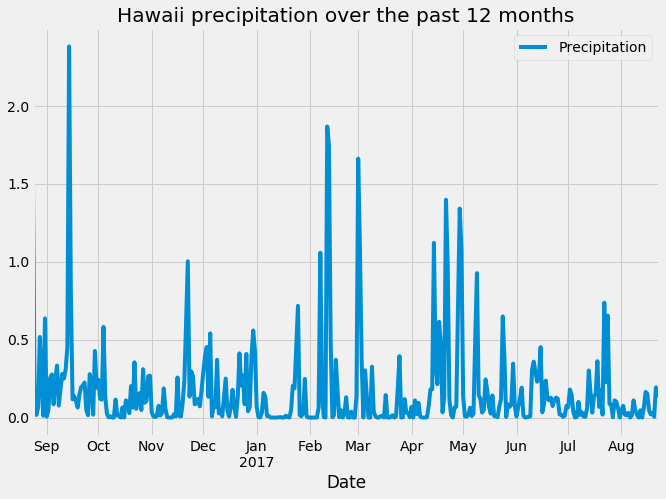

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize = (10,7),
       title = "Hawaii precipitation over the past 12 months")

# Save figure
plt.savefig('Images/12monthsdata.png')
plt.show()

In [17]:
# Use Pandas to calculate the summary statistics for the precipitation data
df['Precipitation'].describe()

count    365.000000
mean       0.169987
std        0.295722
min        0.000000
25%        0.008571
50%        0.070000
75%        0.191667
max        2.380000
Name: Precipitation, dtype: float64

In [18]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.station).count()
print(f"Station Count: {stations}")

Station Count: 9


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active = session.query(Measurement.station,
                       func.count(Measurement.id)).\
                        filter(Measurement.station == Station.station).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.id).desc()).all()

In [20]:
stations_df = pd.DataFrame(active, columns = ['Station ID','Station Count'])
stations_df

,Station ID,Station Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [21]:
most_active = active[0]
print(f"Most Active Station: {most_active[0]}")

Most Active Station: USC00519281


In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp_info = session.query(func.min(Measurement.tobs),
                     func.max(Measurement.tobs),
                     func.avg(Measurement.tobs)).\
                      filter(Measurement.station == 'USC00519281').all()

In [23]:
temp_df = pd.DataFrame(temp_info, columns = ['Lowest Temp Record','Highest Temp Record',"Average Temp Record of USC00519281"])
temp_df

,Lowest Temp Record,Highest Temp Record,Average Temp Record of USC00519281
0,54.0,85.0,71.663781


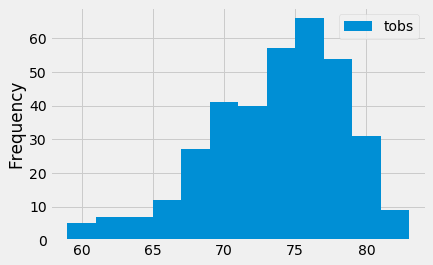

In [25]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
recent_date = session.query(Measurement.date).\
    filter(Measurement.station == most_active[0]).order_by(Measurement.date.desc()).\
    first()

temp_result = session.query(Measurement.date,Measurement.tobs).filter(Measurement.date<=recent_date[0]).\
    filter(Measurement.date>='2016-08-19').filter(Measurement.station == most_active[0]).\
    group_by(Measurement.date).all()

recent_temps = [temp[1] for temp in temp_result]

plt.hist(recent_temps,bins=12,label='tobs')
plt.ylabel('Frequency')
plt.legend()

# Save figure
plt.savefig('Images/tempdata.png')
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
